# Import des bibliothèque nécessaire

In [ ]:

import pandas as pd
import duckdb
from google.colab import files
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# Ajuster les paramètres pour afficher plus de contenu
#pd.set_option('display.max_colwidth', None)  # Pas de limite pour la largeur des colonnes
#pd.set_option('display.max_rows', None)      # Afficher toutes les lignes (si la colonne est longue)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [ ]:
!pip install duckdb --upgrade

In [ ]:
# Connexion à DuckDB
con = duckdb.connect()

# Étape 1 : Charger acteurs principaux avec leurs noms

In [ ]:
# Charger acteurs principaux avec leurs noms
query_actors_with_names = """
    SELECT p.tconst, p.nconst, n.primaryName AS actorName, p.ordering, p.characters
    FROM read_csv_auto(
        'https://datasets.imdbws.com/title.principals.tsv.gz',
        delim='\t', quote='', compression='gzip', header=True, nullstr='\\N', ignore_errors=True
    ) AS p
    JOIN read_csv_auto(
        'https://datasets.imdbws.com/name.basics.tsv.gz',
        delim='\t', quote='', compression='gzip', header=True, nullstr='\\N', ignore_errors=True
    ) AS n
    ON p.nconst = n.nconst
    WHERE p.category IN ('actor', 'actress') AND p.ordering <= 3
    ORDER BY p.tconst, p.ordering;
"""

# Exécuter la requête
actors_with_names = con.execute(query_actors_with_names).fetchdf()

# Afficher un aperçu
actors_with_names.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,nconst,actorName,ordering,characters
0,tt0000005,nm0443482,Charles Kayser,1,"[""Blacksmith""]"
1,tt0000005,nm0653042,John Ott,2,"[""Assistant""]"
2,tt0000007,nm0179163,James J. Corbett,1,None
3,tt0000007,nm0183947,Peter Courtney,2,None
4,tt0000008,nm0653028,Fred Ott,1,"[""Sneezing Man""]"


In [ ]:
actors_with_names.shape

(16093408, 5)

# Étape 2 : Charger réalisateurs avec leurs noms



In [ ]:
# Charger les réalisateurs depuis le fichier title.crew.tsv.gz
# Charger réalisateurs avec leurs noms
query_directors_with_names = """
    SELECT c.tconst, n.primaryName AS directorName
    FROM read_csv_auto(
        'https://datasets.imdbws.com/title.crew.tsv.gz',
        delim='\t', quote='', compression='gzip', header=True, nullstr='\\N', ignore_errors=True
    ) AS c
    JOIN read_csv_auto(
        'https://datasets.imdbws.com/name.basics.tsv.gz',
        delim='\t', quote='', compression='gzip', header=True, nullstr='\\N', ignore_errors=True
    ) AS n
    ON c.directors = n.nconst
    WHERE c.directors IS NOT NULL;
"""

# Exécuter la requête
directors_with_names = con.execute(query_directors_with_names).fetchdf()
directors_with_names.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,directorName
0,tt8413320,Ingmar Bergman
1,tt0050964,James Cagney
2,tt0073559,Kirk Douglas
3,tt11669728,Federico Fellini
4,tt0416238,John Gielgud


# Étape 3 : merge entre les acteurs et réalisateurs

In [ ]:
actors_and_directors = pd.merge(
    actors_with_names,
    directors_with_names,
    on='tconst',
    how='inner'  # Inclut uniquement les titres avec des acteurs et des réalisateurs
)

In [ ]:
actors_and_directors

,tconst,nconst,actorName,ordering,characters,directorName
0,tt0000005,nm0443482,Charles Kayser,1,"[""Blacksmith""]",William K.L. Dickson
1,tt0000005,nm0653042,John Ott,2,"[""Assistant""]",William K.L. Dickson
2,tt0000008,nm0653028,Fred Ott,1,"[""Sneezing Man""]",William K.L. Dickson
3,tt0000009,nm0063086,Blanche Bayliss,1,"[""Miss Geraldine Holbrook (Miss Jerry)""]",Alexander Black
4,tt0000009,nm0183823,William Courtenay,2,"[""Mr. Hamilton""]",Alexander Black
...,...,...,...,...,...,...
10110220,tt9916856,nm10538650,Anna Fitoussi,2,"[""Sandra""]",Johan Planefeldt
10110221,tt9916856,nm10538646,Andreas Demmel,3,"[""Stephan""]",Johan Planefeldt
10110222,tt9916880,nm2784764,Lizzie Waterworth,1,"[""Henry""]",Hilary Audus
10110223,tt9916880,nm1483166,Aidan Cook,2,"[""Rude Ralph""]",Hilary Audus


# Sauvegarde actors_and_directors en csv pour futur utilisation

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
actors_and_directors.to_csv('actors_and_directors.csv', index=False)

# Explications :
# - 'actors_and_directors.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

In [ ]:
# Étape 1 : Téléverser le fichier depuis l'ordinateur
result_tmdb = files.upload()

KeyboardInterrupt: 

In [ ]:
# Étape 2 : Charger le fichier CSV téléversé dans un DataFrame
# Remplacez 'votre_fichier.csv' par le nom exact du fichier téléversé
df_tmdb = pd.read_csv('/content/actors_and_directors.csv')
actors_and_directors.head()

,tconst,nconst,actorName,ordering,characters,directorName
0,tt0000005,nm0443482,Charles Kayser,1,"[""Blacksmith""]",William K.L. Dickson
1,tt0000005,nm0653042,John Ott,2,"[""Assistant""]",William K.L. Dickson
2,tt0000008,nm0653028,Fred Ott,1,"[""Sneezing Man""]",William K.L. Dickson
3,tt0000009,nm0063086,Blanche Bayliss,1,"[""Miss Geraldine Holbrook (Miss Jerry)""]",Alexander Black
4,tt0000009,nm0183823,William Courtenay,2,"[""Mr. Hamilton""]",Alexander Black


# chargement de title basics pour ne garder que les films des 5 dernières années (2020 à 2024)

In [ ]:
# Chargement du csv title basics et requête directe sur les fichiers compressés

result_title_basics = con.execute(f"""
    SELECT tconst, originalTitle, startYear, runtimeMinutes, genres
    FROM read_csv_auto('https://datasets.imdbws.com/title.basics.tsv.gz', delim='\t', quote='', ignore_errors=true)
    WHERE titleType = 'movie'
    AND startYear >= '2020'
    AND startYear <= '2024'
""").fetchdf()

result_title_basics

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,originalTitle,startYear,runtimeMinutes,genres
0,tt0062336,El tango del viudo y su espejo deformante,2020,70,Drama
1,tt0070596,El realismo socialista,2023,78,Drama
2,tt0077684,Histórias de Combóios em Portugal,2022,46,Documentary
3,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller"
4,tt0096167,Stars in Broad Daylight,2024,105,Drama
...,...,...,...,...,...
94561,tt9914192,No Gogó do Paulinho,2020,98,Comedy
94562,tt9914972,Blind Ambition,2021,96,Documentary
94563,tt9916190,Safeguard,2020,95,"Action,Adventure,Thriller"
94564,tt9916270,Il talento del calabrone,2020,84,Thriller


# merge title basics et les acteurs et directeurs

In [ ]:
movies_actors_directors = result_title_basics.merge(actors_and_directors, how='inner', left_on='tconst' , right_on='tconst')
movies_actors_directors

,tconst,originalTitle,startYear,runtimeMinutes,genres,nconst,actorName,ordering,characters,directorName
0,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000123,George Clooney,1,"[""Ron""]",André Szöts
1,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000368,Laura Dern,2,"[""Tina""]",André Szöts
2,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000221,Charlie Sheen,3,"[""Lance""]",André Szöts
3,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094804,Zuhair Abdlulkarim,1,"[""Kasser""]",Ossama Mohammed
4,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094997,Sabah As-Salem,2,"[""Sana""]",Ossama Mohammed
...,...,...,...,...,...,...,...,...,...,...
169272,tt9916270,Il talento del calabrone,2020,84,Thriller,nm3080119,Lorenzo Richelmy,2,"[""Dj Steph""]",Giacomo Cimini
169273,tt9916270,Il talento del calabrone,2020,84,Thriller,nm2063290,Anna Foglietta,3,"[""Rosa Amedei""]",Giacomo Cimini
169274,tt9916362,Akelarre,2020,92,"Drama,History",nm3766704,Amaia Aberasturi,1,"[""Ana""]",Pablo Agüero
169275,tt9916362,Akelarre,2020,92,"Drama,History",nm0107165,Alex Brendemühl,2,"[""Rostegui""]",Pablo Agüero


# chargements des ratings imdb

In [ ]:


# Chargement du csv title ratings et requête directe sur les fichiers compressés

result_title_ratings = con.execute(f"""
    SELECT *
    FROM read_csv_auto('https://datasets.imdbws.com/title.ratings.tsv.gz', delim='\t', quote='', ignore_errors=true)
""").fetchdf()

result_title_ratings

,tconst,averageRating,numVotes
0,tt0000001,5.7,2109
1,tt0000002,5.6,284
2,tt0000003,6.4,2135
3,tt0000004,5.3,182
4,tt0000005,6.2,2863
...,...,...,...
1513751,tt9916730,7.0,12
1513752,tt9916766,7.1,24
1513753,tt9916778,7.2,37
1513754,tt9916840,6.9,11


# merge ratings avec movies_actors_directors

In [ ]:
merge_imdb_total = movies_actors_directors.merge(result_title_ratings, how='left', left_on='tconst' , right_on='tconst')
merge_imdb_total

,tconst,originalTitle,startYear,runtimeMinutes,genres,nconst,actorName,ordering,characters,directorName,averageRating,numVotes
0,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000123,George Clooney,1,"[""Ron""]",André Szöts,2.7,1774.0
1,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000368,Laura Dern,2,"[""Tina""]",André Szöts,2.7,1774.0
2,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000221,Charlie Sheen,3,"[""Lance""]",André Szöts,2.7,1774.0
3,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094804,Zuhair Abdlulkarim,1,"[""Kasser""]",Ossama Mohammed,NaN,NaN
4,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094997,Sabah As-Salem,2,"[""Sana""]",Ossama Mohammed,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
169272,tt9916270,Il talento del calabrone,2020,84,Thriller,nm3080119,Lorenzo Richelmy,2,"[""Dj Steph""]",Giacomo Cimini,5.8,1493.0
169273,tt9916270,Il talento del calabrone,2020,84,Thriller,nm2063290,Anna Foglietta,3,"[""Rosa Amedei""]",Giacomo Cimini,5.8,1493.0
169274,tt9916362,Akelarre,2020,92,"Drama,History",nm3766704,Amaia Aberasturi,1,"[""Ana""]",Pablo Agüero,6.4,5967.0
169275,tt9916362,Akelarre,2020,92,"Drama,History",nm0107165,Alex Brendemühl,2,"[""Rostegui""]",Pablo Agüero,6.4,5967.0


# sauvegarde de merge_imdb_total

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
merge_imdb_total.to_csv('merge_imdb_total.csv', index=False)

# Explications :
# - 'merge_imdb_total.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

In [ ]:
# Étape 1 : Téléverser le fichier depuis l'ordinateur
result_imdb_total = files.upload()


Saving merge_imdb_total.csv to merge_imdb_total.csv


In [ ]:
# Étape 2 : Charger le fichier CSV téléversé dans un DataFrame
# Remplacez 'votre_fichier.csv' par le nom exact du fichier téléversé
df_imdb_total = pd.read_csv('/content/merge_imdb_total.csv')
df_imdb_total.head()

,tconst,originalTitle,startYear,runtimeMinutes,genres,nconst,actorName,ordering,characters,directorName,averageRating,numVotes
0,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000123,George Clooney,1,"[""Ron""]",André Szöts,2.7,1774.0
1,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000368,Laura Dern,2,"[""Tina""]",André Szöts,2.7,1774.0
2,tt0093119,Grizzly II: The Predator,2020,74,"Horror,Music,Thriller",nm0000221,Charlie Sheen,3,"[""Lance""]",André Szöts,2.7,1774.0
3,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094804,Zuhair Abdlulkarim,1,"[""Kasser""]",Ossama Mohammed,NaN,NaN
4,tt0096167,Stars in Broad Daylight,2024,105,Drama,nm1094997,Sabah As-Salem,2,"[""Sana""]",Ossama Mohammed,NaN,NaN


# Chargement du csv tmdb et requête directe sur les fichiers compressés

In [ ]:
result_tmdb = con.execute(f"""
    SELECT *
    FROM read_csv_auto('/content/tmdb_full.csv', ignore_errors=true)
    WHERE original_language = 'fr'
    AND CAST(release_date AS DATE) >= DATE '2020-01-01'
    AND CAST(release_date AS DATE) <= DATE '2024-12-31'
    AND status = 'Released'
""").fetchdf()


In [ ]:
result_tmdb.head()

,adult,backdrop_path,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,production_companies_name,production_companies_country
0,False,None,1250,"['Thriller', 'Science Fiction']",None,1122079,tt27672999,fr,Vendetta,None,...,0,['fr'],Released,None,Vendetta,False,10.0,1,['Kino (FR)'],['']
1,False,/xtyxYV5VyAYrV0IISYlao77D8sW.jpg,0,['Documentary'],None,1121883,tt13974152,fr,Vieillir enfermés,None,...,0,[],Released,None,Vieillir enfermés,False,8.0,1,"['Camera Lucida Productions', 'ARTE']","['FR', 'FR']"
2,False,/o8quSROfTsgaAPyg88iLXVhFtmb.jpg,0,['Documentary'],https://www.youtube.com/watch?v=tJ3yK8loLxA,1120745,tt27653649,fr,"Alain Robert, Retour au Verdon","At 60, Alain Robert has become a legend around...",...,18,['fr'],Released,None,"Alain Robert, Retour au Verdon",False,10.0,1,['Puzzle Media'],['FR']
3,False,None,0,[],None,1120002,tt27641234,fr,"Japon, le combat d'un maître de thé",None,...,0,"['fr', 'ja']",Released,None,"Japon, le combat d'un maître de thé",False,0.0,0,[],[]
4,False,None,0,[],None,1119689,tt27301898,fr,Céline on a Cloudy Day,A Turkish-French actress prepares for an audit...,...,19,"['en', 'fr', 'tr']",Released,A Turkish-French actress prepares for an audit...,Céline on a Cloudy Day,False,0.0,0,[],[]


In [ ]:
result_tmdb.shape

(2072, 25)

In [ ]:
# supression des colonnes qui ne seront pas du tout utilisé
result_tmdb = result_tmdb.drop(['adult', 'backdrop_path', 'genres', 'homepage', 'id', 'original_language', 'status', 'tagline', 'video'], axis=1)

# merge imdb et tmdb

In [ ]:
df_imdb_tmdb_ = df_imdb_total.merge(result_tmdb, how='inner', left_on='tconst' , right_on='imdb_id')


# Sauvegarde de imdb et tmdb

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
df_imdb_tmdb_.to_csv('df_imdb_tmdb_.csv', index=False)

# Explications :
# - 'df_imdb_tmdb_.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

# trié genre pour ne garder que Comedy et Action

In [ ]:
# Étape 1 : Téléverser le fichier depuis l'ordinateur
result_imdb_total = files.upload()

Saving df_imdb_tmdb.csv to df_imdb_tmdb.csv


In [ ]:
# Étape 2 : Charger le fichier CSV téléversé dans un DataFrame
# Remplacez 'votre_fichier.csv' par le nom exact du fichier téléversé
df_imdb_tmdb = pd.read_csv('/content/df_imdb_tmdb.csv')
df_imdb_tmdb.head()

,tconst,originalTitle,startYear,runtimeMinutes,genres,nconst,actorName,ordering,characters,directorName,...,production_countries_y,release_date_y,revenue_y,runtime_y,spoken_languages_y,title_y,vote_average_y,vote_count_y,production_companies_name_y,production_companies_country_y
0,tt10019108,Villa Caprice,2020,103,"Crime,Drama",nm0034390,Niels Arestrup,1,"[""Luc Germon""]",Bernard Stora,...,"['BE', 'FR']",2021-06-02,0,103,['fr'],Villa Caprice,5.625,36,"['JPG Films', 'uMedia', 'uFund', 'Bac Films']","['FR', 'BE', 'BE', 'FR']"
1,tt10019108,Villa Caprice,2020,103,"Crime,Drama",nm0115730,Patrick Bruel,2,"[""Gilles Fontaine""]",Bernard Stora,...,"['BE', 'FR']",2021-06-02,0,103,['fr'],Villa Caprice,5.625,36,"['JPG Films', 'uMedia', 'uFund', 'Bac Films']","['FR', 'BE', 'BE', 'FR']"
2,tt10019108,Villa Caprice,2020,103,"Crime,Drama",nm0001393,Irène Jacob,3,"[""Nancy Fontaine""]",Bernard Stora,...,"['BE', 'FR']",2021-06-02,0,103,['fr'],Villa Caprice,5.625,36,"['JPG Films', 'uMedia', 'uFund', 'Bac Films']","['FR', 'BE', 'BE', 'FR']"
3,tt10023150,Mon cousin,2020,104,Comedy,nm0512071,Vincent Lindon,1,"[""Pierre Pastié""]",Jan Kounen,...,['FR'],2020-09-30,2982559,107,['fr'],My Cousin,5.500,90,"['Eskwad', 'TF1 Films Production', 'uMedia', '...","['FR', 'FR', 'BE', 'BE']"
4,tt10023150,Mon cousin,2020,104,Comedy,nm12571544,Matei Dussarps,2,"[""Adrien jeune""]",Jan Kounen,...,['FR'],2020-09-30,2982559,107,['fr'],My Cousin,5.500,90,"['Eskwad', 'TF1 Films Production', 'uMedia', '...","['FR', 'FR', 'BE', 'BE']"


In [ ]:
# Filtrer le DataFrame pour ne conserver que les lignes où la colonne 'genres' contient les genres "Action" ou "Comedy".
# Cela permet de supprimer toutes les autres lignes ne correspondant pas à ces genres.

df_comedy_action = df_imdb_tmdb.loc[
    df_imdb_tmdb['genres'].str.contains('Action|Comedy', na=False)
]

# Afficher la nouvelle taille du DataFrame (nombre de lignes et de colonnes) après le filtrage
df_comedy_action.shape

(899, 44)

In [ ]:
# Ce code filtre la colonne 'genres' pour ne conserver que les genres "Comedy" et "Action",
# en supprimant tous les autres genres dans les valeurs de cette colonne.

# Définition de l'ensemble des genres autorisés
genres_autoriser = {"Comedy", "Action"}

# Transformation de la colonne 'genres' pour ne conserver que les genres autorisés
df_comedy_action['genres'] = df_comedy_action['genres'].apply(
    lambda string: ",".join([genre for genre in string.split(",") if genre in genres_autoriser])
)

# Affichage du DataFrame mis à jour
df_comedy_action

<ipython-input-61-194810505dad>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comedy_action['genres'] = df_comedy_action['genres'].apply(


,tconst,originalTitle,startYear,runtimeMinutes,genres,nconst,actorName,ordering,characters,directorName,...,production_countries_y,release_date_y,revenue_y,runtime_y,spoken_languages_y,title_y,vote_average_y,vote_count_y,production_companies_name_y,production_companies_country_y
3,tt10023150,Mon cousin,2020,104,Comedy,nm0512071,Vincent Lindon,1,"[""Pierre Pastié""]",Jan Kounen,...,['FR'],2020-09-30,2982559,107,['fr'],My Cousin,5.500,90,"['Eskwad', 'TF1 Films Production', 'uMedia', '...","['FR', 'FR', 'BE', 'BE']"
4,tt10023150,Mon cousin,2020,104,Comedy,nm12571544,Matei Dussarps,2,"[""Adrien jeune""]",Jan Kounen,...,['FR'],2020-09-30,2982559,107,['fr'],My Cousin,5.500,90,"['Eskwad', 'TF1 Films Production', 'uMedia', '...","['FR', 'FR', 'BE', 'BE']"
5,tt10023150,Mon cousin,2020,104,Comedy,nm0033389,Pascale Arbillot,3,"[""Olivia Pastié""]",Jan Kounen,...,['FR'],2020-09-30,2982559,107,['fr'],My Cousin,5.500,90,"['Eskwad', 'TF1 Films Production', 'uMedia', '...","['FR', 'FR', 'BE', 'BE']"
15,tt10092752,La terre et le sang,2020,80,Action,nm0098793,Sami Bouajila,1,"[""Saïd""]",Julien Leclercq,...,"['BE', 'FR']",2020-04-17,0,80,['fr'],Earth and Blood,6.164,274,"['Labyrinthe Films', 'uMedia']","['FR', 'BE']"
16,tt10092752,La terre et le sang,2020,80,Action,nm0248254,Eriq Ebouaney,2,"[""Adama""]",Julien Leclercq,...,"['BE', 'FR']",2020-04-17,0,80,['fr'],Earth and Blood,6.164,274,"['Labyrinthe Films', 'uMedia']","['FR', 'BE']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,tt9894450,Felicità,2020,81,Comedy,nm10529368,Rita Merle,2,"[""Tommy""]",Bruno Merle,...,['FR'],2020-07-15,236880,81,['fr'],Felicità,7.072,104,"['Unité', ""Jack N'a Qu'un Oeil"", 'Canal+']","['FR', 'FR', 'FR']"
2195,tt9894450,Felicità,2020,81,Comedy,nm4166709,Camille Rutherford,3,"[""Chloé""]",Bruno Merle,...,['FR'],2020-07-15,236880,81,['fr'],Felicità,7.072,104,"['Unité', ""Jack N'a Qu'un Oeil"", 'Canal+']","['FR', 'FR', 'FR']"
2196,tt9908390,Le lion,2020,95,Comedy,nm0200702,Dany Boon,1,"[""Léo Milan""]",Ludovic Colbeau-Justin,...,['FR'],2020-01-29,0,95,['fr'],The Lion,5.328,172,"['TF1 Studio', 'Monkey Pack Films', 'Pathé', '...","['FR', 'FR', 'FR', 'FR', 'BE']"
2197,tt9908390,Le lion,2020,95,Comedy,nm1081573,Philippe Katerine,2,"[""Romain Martin""]",Ludovic Colbeau-Justin,...,['FR'],2020-01-29,0,95,['fr'],The Lion,5.328,172,"['TF1 Studio', 'Monkey Pack Films', 'Pathé', '...","['FR', 'FR', 'FR', 'FR', 'BE']"


In [ ]:
# check les noms des colonnes pour suppression
df_comedy_action.columns

Index(['tconst', 'originalTitle', 'startYear', 'runtimeMinutes', 'genres',
       'nconst', 'actorName', 'ordering', 'characters', 'directorName',
       'averageRating', 'numVotes', 'budget_x', 'imdb_id_x',
       'original_title_x', 'overview_x', 'popularity_x', 'poster_path_x',
       'production_countries_x', 'release_date_x', 'revenue_x', 'runtime_x',
       'spoken_languages_x', 'title_x', 'vote_average_x', 'vote_count_x',
       'production_companies_name_x', 'production_companies_country_x',
       'budget_y', 'imdb_id_y', 'original_title_y', 'overview_y',
       'popularity_y', 'poster_path_y', 'production_countries_y',
       'release_date_y', 'revenue_y', 'runtime_y', 'spoken_languages_y',
       'title_y', 'vote_average_y', 'vote_count_y',
       'production_companies_name_y', 'production_companies_country_y'],
      dtype='object')

In [ ]:
# suppression de tout les colonnes doublons
df_comedy_action = df_comedy_action.drop(['nconst', 'ordering', 'imdb_id_x',
       'original_title_x', 'release_date_x', 'runtime_x', 'budget_y', 'imdb_id_y', 'original_title_y', 'overview_y',
       'popularity_y', 'poster_path_y', 'production_countries_y',
       'release_date_y', 'revenue_y', 'runtime_y', 'spoken_languages_y',
       'title_y', 'vote_average_y', 'vote_count_y',
       'production_companies_name_y', 'production_companies_country_y'], axis=1)

In [ ]:
df_comedy_action.shape

(899, 22)

In [ ]:
# suppresion de toutes langues parlées dans les films qui ne sont pas française
df_comedy_action = df_comedy_action.loc[df_comedy_action['spoken_languages_x'].apply(lambda liste: all(elem == 'fr' for elem in eval(liste)))]

In [ ]:
# suppresion des compagnies de production des films qui n'ont pas au moins une fois dans sa liste FR
df_comedy_action = df_comedy_action.loc[df_comedy_action['production_companies_country_x'].apply(lambda liste: any(elem == 'FR' for elem in eval(liste)))]


# analyses des 2 colonnes moyenne des notes pour n'en garder q'une

In [ ]:
# observation des statistiques pour les notes moyennes des 2 colonnes pour futur remplacements
df_comedy_action[['averageRating', 'vote_average_x']].describe()

,averageRating,vote_average_x
count,612.000000,615.000000
mean,5.737092,5.849885
std,0.761435,1.234802
min,3.300000,0.000000
25%,5.400000,5.406000
50%,5.800000,6.000000
75%,6.300000,6.563000
max,8.000000,8.250000


In [ ]:
# indice 622, 623, 6224 ayant une valeur manquantes (même films)
df_comedy_action.loc[df_comedy_action['averageRating'].isna() == True]

,tconst,originalTitle,startYear,runtimeMinutes,genres,actorName,characters,directorName,averageRating,numVotes,...,popularity_x,poster_path_x,production_countries_x,revenue_x,spoken_languages_x,title_x,vote_average_x,vote_count_x,production_companies_name_x,production_companies_country_x
622,tt12989690,La cygne des héros,2022,76,Comedy,Rachel Nasschaert,"[""Lola Loiseau""]",Claude Saussereau,NaN,NaN,...,1.4,/6beyqA6OIcl2vHtCzkyFRoFVDnh.jpg,['FR'],0,['fr'],Le cygne des héros,5.0,2,['Bavasa Films'],['FR']
623,tt12989690,La cygne des héros,2022,76,Comedy,Raphaël Almosni,"[""Pierre Péroni""]",Claude Saussereau,NaN,NaN,...,1.4,/6beyqA6OIcl2vHtCzkyFRoFVDnh.jpg,['FR'],0,['fr'],Le cygne des héros,5.0,2,['Bavasa Films'],['FR']
624,tt12989690,La cygne des héros,2022,76,Comedy,Paul Linte,"[""Emile""]",Claude Saussereau,NaN,NaN,...,1.4,/6beyqA6OIcl2vHtCzkyFRoFVDnh.jpg,['FR'],0,['fr'],Le cygne des héros,5.0,2,['Bavasa Films'],['FR']


In [ ]:
# remplacement de la valeur manquantes par 3.6 qui est la notes donné sur internet du films
df_comedy_action['averageRating'] = df_comedy_action['averageRating'].fillna(3.6)


# analyses des 2 colonnes mombres des notes pour n'en garder q'une

In [ ]:
# observation des statistiques pour les notes moyennes des 2 colonnes pour futur remplacements
df_comedy_action[['numVotes', 'vote_count_x']].describe()

,numVotes,vote_count_x
count,612.000000,615.000000
mean,1692.062092,102.609756
std,2997.357163,138.604341
min,9.000000,0.000000
25%,264.250000,20.000000
50%,564.500000,53.000000
75%,1526.750000,131.000000
max,23481.000000,1033.000000


In [ ]:
# lignes 622, 623, 6224 ayant une valeur manquantes (même films)
df_comedy_action.loc[df_comedy_action['numVotes'].isna() == True]


,tconst,originalTitle,startYear,runtimeMinutes,genres,actorName,characters,directorName,averageRating,numVotes,...,popularity_x,poster_path_x,production_countries_x,revenue_x,spoken_languages_x,title_x,vote_average_x,vote_count_x,production_companies_name_x,production_companies_country_x
622,tt12989690,La cygne des héros,2022,76,Comedy,Rachel Nasschaert,"[""Lola Loiseau""]",Claude Saussereau,3.6,NaN,...,1.4,/6beyqA6OIcl2vHtCzkyFRoFVDnh.jpg,['FR'],0,['fr'],Le cygne des héros,5.0,2,['Bavasa Films'],['FR']
623,tt12989690,La cygne des héros,2022,76,Comedy,Raphaël Almosni,"[""Pierre Péroni""]",Claude Saussereau,3.6,NaN,...,1.4,/6beyqA6OIcl2vHtCzkyFRoFVDnh.jpg,['FR'],0,['fr'],Le cygne des héros,5.0,2,['Bavasa Films'],['FR']
624,tt12989690,La cygne des héros,2022,76,Comedy,Paul Linte,"[""Emile""]",Claude Saussereau,3.6,NaN,...,1.4,/6beyqA6OIcl2vHtCzkyFRoFVDnh.jpg,['FR'],0,['fr'],Le cygne des héros,5.0,2,['Bavasa Films'],['FR']


In [ ]:
# remplacement de la valeur manquantes par 3.6 qui est la notes donné sur internet du films
df_comedy_action['numVotes'] = df_comedy_action['numVotes'].fillna(43)




In [ ]:
# vérification des valeurs manquantes de la colonnes
df_comedy_action.isna().sum()


,0
tconst,0
originalTitle,0
startYear,0
runtimeMinutes,0
genres,0
actorName,0
characters,0
directorName,0
averageRating,0
numVotes,0


In [ ]:
# indifiant du film tt11179020 ayant une valeur manquantes (même films) et indifiant du film tt9568486 ayant une valeur manquantes (même films)
df_comedy_action.loc[df_comedy_action['overview_x'].isna() == True]

,tconst,originalTitle,startYear,runtimeMinutes,genres,actorName,characters,directorName,averageRating,numVotes,...,popularity_x,poster_path_x,production_countries_x,revenue_x,spoken_languages_x,title_x,vote_average_x,vote_count_x,production_companies_name_x,production_companies_country_x
298,tt11179020,Les cobayes,2020,80,Comedy,Thomas Ngijol,"[""Adam""]",Emmanuel Poulain-Arnaud,5.6,89.0,...,2.059,/q9B5cyRzNMas7Cg9VuJ6Lsdz1XH.jpg,['FR'],0,['fr'],Les Cobayes,4.4,9,"['Fluxus Films', 'Davis Films']","['FR', '']"
299,tt11179020,Les cobayes,2020,80,Comedy,Judith Chemla,"[""Charlotte""]",Emmanuel Poulain-Arnaud,5.6,89.0,...,2.059,/q9B5cyRzNMas7Cg9VuJ6Lsdz1XH.jpg,['FR'],0,['fr'],Les Cobayes,4.4,9,"['Fluxus Films', 'Davis Films']","['FR', '']"
300,tt11179020,Les cobayes,2020,80,Comedy,Dominique Valadié,"[""Docteur Mangin""]",Emmanuel Poulain-Arnaud,5.6,89.0,...,2.059,/q9B5cyRzNMas7Cg9VuJ6Lsdz1XH.jpg,['FR'],0,['fr'],Les Cobayes,4.4,9,"['Fluxus Films', 'Davis Films']","['FR', '']"
2145,tt9568486,Mine de rien,2020,85,Comedy,Arnaud Ducret,"[""Arnault""]",Mathias Mlekuz,5.4,270.0,...,3.615,/5Vz6qJXoekRMHiqXmsuO5VALnmg.jpg,['FR'],0,['fr'],Mine de rien,5.8,53,"['Orange Studio', 'OCS', 'M.E.S. Productions',...","['FR', 'FR', 'FR', 'FR']"
2146,tt9568486,Mine de rien,2020,85,Comedy,Philippe Rebbot,"[""Di Lello""]",Mathias Mlekuz,5.4,270.0,...,3.615,/5Vz6qJXoekRMHiqXmsuO5VALnmg.jpg,['FR'],0,['fr'],Mine de rien,5.8,53,"['Orange Studio', 'OCS', 'M.E.S. Productions',...","['FR', 'FR', 'FR', 'FR']"
2147,tt9568486,Mine de rien,2020,85,Comedy,Mélanie Bernier,"[""Stella""]",Mathias Mlekuz,5.4,270.0,...,3.615,/5Vz6qJXoekRMHiqXmsuO5VALnmg.jpg,['FR'],0,['fr'],Mine de rien,5.8,53,"['Orange Studio', 'OCS', 'M.E.S. Productions',...","['FR', 'FR', 'FR', 'FR']"


In [ ]:
# commentaires trouver su imdb :
# les cobayes : "A comedy about the wear and tear of a couple, yet here quite young, with the pretext of testing a drug that cures couples and makes them renew (respect, trust, attraction). The cast is judicious and confronts very different phlegms between Thomas Ngijol and Judith Chemla, both perfect. The quality of the film is to manage to make a fair film, that is to say, at the same time relative to a certain truth and which avoids, not necessarily accurately, the traps that such a subject could have produced in a primary and vulgar vein. The author takes the opportunity to put a few jabs at the medical staff, represented here without empathy for its guinea pigs."
# Mine de rien : "In a small town in the North of France, a region that was the flagship of the mining industry for many years, young and old alike are struggling to find work. While several former workers decide to hold a siege in front of a disused coal mine that is to be dismantled, two long-term unemployed men, Di Lello, whose wife runs the household, and Arnaud, a divorced man who has to take care of his sick mother, have the excellent idea of building an "artisanal" amusement park. By saving the mine and its memory, they will regain strength and dignity."

# Remplacer la valeur manquante dans une colonne spécifique
df_comedy_action.loc[df_comedy_action['tconst'] == 'tt11179020', 'overview_x'] = "A comedy about the wear and tear of a couple, yet here quite young, with the pretext of testing a drug that cures couples and makes them renew (respect, trust, attraction). The cast is judicious and confronts very different phlegms between Thomas Ngijol and Judith Chemla, both perfect. The quality of the film is to manage to make a fair film, that is to say, at the same time relative to a certain truth and which avoids, not necessarily accurately, the traps that such a subject could have produced in a primary and vulgar vein. The author takes the opportunity to put a few jabs at the medical staff, represented here without empathy for its guinea pigs."
df_comedy_action.loc[df_comedy_action['tconst'] == 'tt11179020', 'overview_x'] = "A comedy about the wear and tear of a couple, yet here quite young, with the pretext of testing a drug that cures couples and makes them renew (respect, trust, attraction). The cast is judicious and confronts very different phlegms between Thomas Ngijol and Judith Chemla, both perfect. The quality of the film is to manage to make a fair film, that is to say, at the same time relative to a certain truth and which avoids, not necessarily accurately, the traps that such a subject could have produced in a primary and vulgar vein. The author takes the opportunity to put a few jabs at the medical staff, represented here without empathy for its guinea pigs."
df_comedy_action.loc[df_comedy_action['tconst'] == 'tt11179020', 'overview_x'] = "A comedy about the wear and tear of a couple, yet here quite young, with the pretext of testing a drug that cures couples and makes them renew (respect, trust, attraction). The cast is judicious and confronts very different phlegms between Thomas Ngijol and Judith Chemla, both perfect. The quality of the film is to manage to make a fair film, that is to say, at the same time relative to a certain truth and which avoids, not necessarily accurately, the traps that such a subject could have produced in a primary and vulgar vein. The author takes the opportunity to put a few jabs at the medical staff, represented here without empathy for its guinea pigs."

df_comedy_action.loc[df_comedy_action['tconst'] == 'tt9568486', 'overview_x'] = "In a small town in the North of France, a region that was the flagship of the mining industry for many years, young and old alike are struggling to find work. While several former workers decide to hold a siege in front of a disused coal mine that is to be dismantled, two long-term unemployed men, Di Lello, whose wife runs the household, and Arnaud, a divorced man who has to take care of his sick mother, have the excellent idea of building an 'artisanal' amusement park. By saving the mine and its memory, they will regain strength and dignity."
df_comedy_action.loc[df_comedy_action['tconst'] == 'tt9568486', 'overview_x'] = "In a small town in the North of France, a region that was the flagship of the mining industry for many years, young and old alike are struggling to find work. While several former workers decide to hold a siege in front of a disused coal mine that is to be dismantled, two long-term unemployed men, Di Lello, whose wife runs the household, and Arnaud, a divorced man who has to take care of his sick mother, have the excellent idea of building an 'artisanal' amusement park. By saving the mine and its memory, they will regain strength and dignity."
df_comedy_action.loc[df_comedy_action['tconst'] == 'tt9568486', 'overview_x'] = "In a small town in the North of France, a region that was the flagship of the mining industry for many years, young and old alike are struggling to find work. While several former workers decide to hold a siege in front of a disused coal mine that is to be dismantled, two long-term unemployed men, Di Lello, whose wife runs the household, and Arnaud, a divorced man who has to take care of his sick mother, have the excellent idea of building an 'artisanal' amusement park. By saving the mine and its memory, they will regain strength and dignity."


# remplacer les poster_path manquant en utilisant l'API

In [ ]:
df_comedy_action.loc[df_comedy_action['poster_path_x'].isna() == True]

,tconst,originalTitle,startYear,runtimeMinutes,genres,actorName,characters,directorName,averageRating,numVotes,...,popularity_x,poster_path_x,production_countries_x,revenue_x,spoken_languages_x,title_x,vote_average_x,vote_count_x,production_companies_name_x,production_companies_country_x
1050,tt14495660,Sexygénaires,2023,81,Comedy,Thierry Lhermitte,"[""Michel""]",Robin Sykes,5.4,168.0,...,3.035,NaN,['FR'],0,['fr'],Sexygénaires,0.0,0,"['Apollo Films', '24 25 Films', 'Orange Studio']","['FR', 'FR', 'FR']"
1051,tt14495660,Sexygénaires,2023,81,Comedy,Patrick Timsit,"[""Denis""]",Robin Sykes,5.4,168.0,...,3.035,NaN,['FR'],0,['fr'],Sexygénaires,0.0,0,"['Apollo Films', '24 25 Films', 'Orange Studio']","['FR', 'FR', 'FR']"
1052,tt14495660,Sexygénaires,2023,81,Comedy,Zineb Triki,"[""Manon""]",Robin Sykes,5.4,168.0,...,3.035,NaN,['FR'],0,['fr'],Sexygénaires,0.0,0,"['Apollo Films', '24 25 Films', 'Orange Studio']","['FR', 'FR', 'FR']"
1574,tt19381382,Cocorico,2024,92,Comedy,Christian Clavier,"[""Frédéric Bouvier Sauvage""]",Julien Hervé,5.8,2697.0,...,1.060,NaN,['FR'],0,['fr'],Cocorico,0.0,0,"['M6 Films', 'Belga Films', 'SND', 'White and ...","['FR', 'BE', 'FR', '']"
1575,tt19381382,Cocorico,2024,92,Comedy,Didier Bourdon,"[""Gérard Martin""]",Julien Hervé,5.8,2697.0,...,1.060,NaN,['FR'],0,['fr'],Cocorico,0.0,0,"['M6 Films', 'Belga Films', 'SND', 'White and ...","['FR', 'BE', 'FR', '']"
1576,tt19381382,Cocorico,2024,92,Comedy,Sylvie Testud,"[""Nicole Martin""]",Julien Hervé,5.8,2697.0,...,1.060,NaN,['FR'],0,['fr'],Cocorico,0.0,0,"['M6 Films', 'Belga Films', 'SND', 'White and ...","['FR', 'BE', 'FR', '']"


In [ ]:
# récupérer les deux poster_path manquant

API_KEY = "e7bd01225df3569a1a41477ab0718701"

posters = {}
for tconst in ['tt14495660', 'tt19381382']:
  url = f"https://api.themoviedb.org/3/find/{tconst}?api_key={API_KEY}&external_source=imdb_id&language=fr"

  response = requests.get(url)
  rep = response.json()
  poster = rep['movie_results'][0]['poster_path']
  df_comedy_action.loc[df_comedy_action['tconst'] == tconst, 'poster_path_x'] = poster
  posters[tconst] = poster

posters

{'tt14495660': '/31dkjJJty4gVA2t5LKi2WBd9x15.jpg',
 'tt19381382': '/nAp0VzDEOn7rvHrc63DHqrMOqK4.jpg'}

In [ ]:
# Toutes les valeurs manquantes ont été traité
df_comedy_action.isna().sum()


,0
tconst,0
originalTitle,0
startYear,0
runtimeMinutes,0
genres,0
actorName,0
characters,0
directorName,0
averageRating,0
numVotes,0


In [ ]:
# aucun duplicate
df_comedy_action.duplicated().sum()

0

In [ ]:
# suppression des colonnes inutiles
df_comedy_action = df_comedy_action.drop(['production_countries_x', 'spoken_languages_x', 'title_x',
       'vote_average_x', 'vote_count_x', 'production_companies_name_x',
       'production_companies_country_x'], axis=1)

In [ ]:
# renommer les titres des colonnes
df_comedy_action = df_comedy_action.rename(columns={
    'tconst' : 'id_film',
    'originalTitle' : 'titre_original',
    'startYear' : 'annee_sortie',
    'runtimeMinutes' : 'duree',
    'actorName' : 'acteurs',
    'characters' : 'personnage_film',
    'directorName' : 'directeur',
    'averageRating' : 'moyenne_notes',
    'numVotes' : 'nombre_votes',
    'budget_x' : 'budget',
    'overview_x' : 'description_en',
    'popularity_x' : 'popularite',
    'poster_path_x' : 'chemin_affiche',
    'revenue_x' : 'revenue'
})

In [ ]:
# modification apparence et type de la colonne
df_comedy_action['personnage_film'] = df_comedy_action['personnage_film'].apply(lambda liste: ",".join(eval(liste)))

In [ ]:
df_comedy_action.shape

(615, 15)

# grouper les titres des films et grouper les noms des acteurs, directeurs, characters

In [ ]:
df_comedy_action.columns

Index(['id_film', 'titre_original', 'annee_sortie', 'duree', 'genres',
       'acteurs', 'personnage_film', 'directeur', 'moyenne_notes',
       'nombre_votes', 'budget', 'description_en', 'popularite',
       'chemin_affiche', 'revenue'],
      dtype='object')

# Grouper le DataFrame 'df_comedy_action' par la colonne 'id_film'

In [ ]:
# Grouper le DataFrame 'df_comedy_action' par la colonne 'id_film'

df_comedy_action = df_comedy_action.groupby('id_film').agg({
    # Pour chaque groupe, garder uniquement la première valeur de 'titre_original'
    'titre_original': 'first',
    # Garder la première valeur de 'annee_sortie'
    'annee_sortie': 'first',
    # Garder la première valeur de 'duree'
    'duree': 'first',
    # Garder la première valeur de 'genres'
    'genres': 'first',
    # Convertir les valeurs de 'acteurs' en une liste (regroupe toutes les valeurs distinctes pour chaque groupe)
    'acteurs': lambda x: list(x),
    # Convertir les valeurs de 'personnage_film' en une liste (regroupe toutes les valeurs distinctes pour chaque groupe)
    'personnage_film': lambda x: list(x),
    # Garder la première valeur de 'directeur a'
    'directeur': 'first',
    # Garder la première valeur de 'moyenne_notes'
    'moyenne_notes': 'first',
    # Garder la première valeur de 'nombre_votes'
    'nombre_votes': 'first',
    # Garder la première valeur de 'budget'
    'budget': 'first',
    # Garder la première valeur de 'description_en'
    'description_en': 'first',
    # Garder la première valeur de 'popularite'
    'popularite': 'first',
    # Garder la première valeur de 'chemin_affiche'
    'chemin_affiche': 'first',
    # Garder la première valeur de 'revenue'
    'revenue': 'first'
}).reset_index()   # Réinitialiser l'index du DataFrame pour transformer 'tconst' de l'index en une colonne classique

In [ ]:
df_comedy_action.shape

(206, 15)

# rajouter une colonne description description en français grâce l'API de tmdb

In [ ]:

# Fonction pour extraire la description en français via TMDB API
def extraire_description_fr(id_film):
    API_KEY = "e7bd01225df3569a1a41477ab0718701"  # Votre clé TMDB
    url = f"https://api.themoviedb.org/3/find/{id_film}?api_key={API_KEY}&external_source=imdb_id&language=fr"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Vérifie les erreurs HTTP
        data = response.json()

        # Vérifie si le film est trouvé
        if 'movie_results' in data and len(data['movie_results']) > 0:
            return data['movie_results'][0].get('overview', 'Description non disponible')
        else:
            return 'Film non trouvé sur TMDB'
    except Exception as e:
        return f"Erreur: {e}"  # Capture les erreurs

# Appliquer la fonction pour créer une nouvelle colonne
df_comedy_action['description_fr'] = df_comedy_action['id_film'].apply(extraire_description_fr)

# Afficher les résultats
print(df_comedy_action[['id_film', 'description_fr']].head())


      id_film                                     description_fr
0  tt10023150  Pierre est le PDG du groupe Pastié qui réunit ...
1  tt10092752  Après plusieurs années à la tête d'une scierie...
2  tt10123698  Alex, petit garçon gracieux de 9 ans qui navig...
3  tt10127684  Pris entre la corruption policière et la guerr...
4  tt10143308  Tout sourit à Audrey et Jérôme. Ils ont trois ...


In [ ]:
df_comedy_action

,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,budget,description_en,popularite,chemin_affiche,revenue,description_fr
0,tt10023150,Mon cousin,2020,104,Comedy,"[Vincent Lindon, Matei Dussarps, Pascale Arbil...","[Pierre Pastié, Adrien jeune, Olivia Pastié]",Jan Kounen,5.3,706.0,10854516,Pierre is the highly successful CEO of a large...,4.697,/wRGGPn8iukAYqCwbqMyw60DH6KV.jpg,2982559,Pierre est le PDG du groupe Pastié qui réunit ...
1,tt10092752,La terre et le sang,2020,80,Action,"[Sami Bouajila, Eriq Ebouaney, Samy Seghir]","[Saïd, Adama, Yanis]",Julien Leclercq,5.2,2958.0,0,A sawmill owner and his teenage daughter becom...,12.913,/23S0NEXXOMhhXhF566Pw5sx7hnZ.jpg,0,Après plusieurs années à la tête d'une scierie...
2,tt10123698,Miss,2020,107,Comedy,"[Alexandre Wetter, Pascale Arbillot, Isabelle ...","[Alex Dufresnoy, Amanda, Yolande]",Ruben Alves,6.4,1016.0,0,A young man seeking his sexual identity decide...,5.732,/fAXgta3EKncuvZeZFjT47GnVqi0.jpg,0,"Alex, petit garçon gracieux de 9 ans qui navig..."
3,tt10127684,Bronx,2020,116,Action,"[Lannick Gautry, Lannick Gautry, Stanislas Mer...","[Richard, Anti-gang cop, Willy]",Olivier Marchal,6.1,10222.0,0,Caught in the crosshairs of police corruption ...,12.838,/9HT9982bzgN5on1sLRmc1GMn6ZC.jpg,0,Pris entre la corruption policière et la guerr...
4,tt10143308,Tout nous sourit,2020,101,Comedy,"[Elsa Zylberstein, Stéphane De Groodt, Guy Mar...","[Audrey Pottier, Jérôme Pottier, Henri Pottier]",Mélissa Drigeard,5.4,371.0,0,"The members of an apparently happy couple, eac...",2.680,/uyZG3WYk3oUqbRYunL92N8MFzZT.jpg,0,Tout sourit à Audrey et Jérôme. Ils ont trois ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,tt9568486,Mine de rien,2020,85,Comedy,"[Arnaud Ducret, Philippe Rebbot, Mélanie Bernier]","[Arnault, Di Lello, Stella]",Mathias Mlekuz,5.4,270.0,0,"In a small town in the North of France, a regi...",3.615,/5Vz6qJXoekRMHiqXmsuO5VALnmg.jpg,0,Dans une région qui fut le fleuron de l'indust...
202,tt9665786,Un tour chez ma fille,2021,88,Comedy,"[Josiane Balasko, Mathilde Seigner, Jérôme Com...","[Jacqueline Mazerin, Carole Bordier, Alain Bor...",Eric Lavaine,5.2,486.0,0,"While her apartment is being renovated, Jacque...",7.635,/hG4yUTzeWk7728l1C0xZzKLIPtJ.jpg,0,"Cette fois-ci, c’est elle qui débarque! Jacque..."
203,tt9844322,Kaamelott - Premier volet,2021,120,Comedy,"[Alexandre Astier, Lionnel Astier, Antoine de ...","[Arthur, Léodagan de Carmélide, Dagonet]",Alexandre Astier,6.1,4210.0,17516235,"Following the end of the acclaimed tv series, ...",13.254,/4mcovnajaLoy7dbv5arykJjDFFC.jpg,19002036,Le tyrannique Lancelot-du-Lac et ses mercenair...
204,tt9894450,Felicità,2020,81,Comedy,"[Pio Marmaï, Rita Merle, Camille Rutherford]","[Timothée dit Tim, Tommy, Chloé]",Bruno Merle,6.6,1073.0,0,"Tommy, 11 years old, is on the road again with...",5.208,/yhAiRXQUkMRnalRZFr1jiRCohjM.jpg,236880,"Pour Tim et Chloé, le bonheur c'est au jour le..."


In [ ]:
# 87 % des budget à 0 , surment une erreur (colonne à supprimer)
df_comedy_action['revenue'].value_counts(True)

,proportion
revenue,
0,0.878641
2982559,0.004854
19002036,0.004854
5127426,0.004854
5460628,0.004854
1946816,0.004854
4834952,0.004854
1162077,0.004854
5843307,0.004854


In [ ]:
# 76 % des budget à 0 , surment une erreur (colonne à supprimer)
df_comedy_action['budget'].value_counts(True)

,proportion
budget,
0,0.766990
5000000,0.014563
3900000,0.009709
4000000,0.009709
6000000,0.009709
200000,0.004854
4100000,0.004854
7940000,0.004854
5460000,0.004854


In [ ]:
# suppression des deux colonnes revenue et budget
df_comedy_action = df_comedy_action.drop(['revenue', 'budget'], axis=1)

In [ ]:
df_comedy_action.shape

(206, 14)

# extraction du dataframe finial

In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
df_comedy_action.to_csv('df_français_comedy_action.csv', index=False)

# Explications :
# - 'df_français_comedy_action.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

In [ ]:
# Étape 1 : Téléverser le fichier depuis l'ordinateur
result_français_comedy_action = files.upload()


Saving df_français_comedy_action.csv to df_français_comedy_action.csv


In [ ]:
# Étape 2 : Charger le fichier CSV téléversé dans un DataFrame
# Remplacez 'votre_fichier.csv' par le nom exact du fichier téléversé
df_français_comedy_action = pd.read_csv('/content/df_français_comedy_action.csv')
df_français_comedy_action.head()

,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,description_en,popularite,chemin_affiche,description_fr
0,tt10023150,Mon cousin,2020,104,Comedy,"['Vincent Lindon', 'Matei Dussarps', 'Pascale ...","['Pierre Pastié', 'Adrien jeune', 'Olivia Past...",Jan Kounen,5.3,706.0,Pierre is the highly successful CEO of a large...,4.697,/wRGGPn8iukAYqCwbqMyw60DH6KV.jpg,Pierre est le PDG du groupe Pastié qui réunit ...
1,tt10092752,La terre et le sang,2020,80,Action,"['Sami Bouajila', 'Eriq Ebouaney', 'Samy Seghir']","['Saïd', 'Adama', 'Yanis']",Julien Leclercq,5.2,2958.0,A sawmill owner and his teenage daughter becom...,12.913,/23S0NEXXOMhhXhF566Pw5sx7hnZ.jpg,Après plusieurs années à la tête d'une scierie...
2,tt10123698,Miss,2020,107,Comedy,"['Alexandre Wetter', 'Pascale Arbillot', 'Isab...","['Alex Dufresnoy', 'Amanda', 'Yolande']",Ruben Alves,6.4,1016.0,A young man seeking his sexual identity decide...,5.732,/fAXgta3EKncuvZeZFjT47GnVqi0.jpg,"Alex, petit garçon gracieux de 9 ans qui navig..."
3,tt10127684,Bronx,2020,116,Action,"['Lannick Gautry', 'Lannick Gautry', 'Stanisla...","['Richard', 'Anti-gang cop', 'Willy']",Olivier Marchal,6.1,10222.0,Caught in the crosshairs of police corruption ...,12.838,/9HT9982bzgN5on1sLRmc1GMn6ZC.jpg,Pris entre la corruption policière et la guerr...
4,tt10143308,Tout nous sourit,2020,101,Comedy,"['Elsa Zylberstein', 'Stéphane De Groodt', 'Gu...","['Audrey Pottier', 'Jérôme Pottier', 'Henri Po...",Mélissa Drigeard,5.4,371.0,"The members of an apparently happy couple, eac...",2.680,/uyZG3WYk3oUqbRYunL92N8MFzZT.jpg,Tout sourit à Audrey et Jérôme. Ils ont trois ...


# insérer vidéo bande annonce pour le streamlit

In [ ]:
import requests
import pandas as pd

# Clé API et DataFrame existant
API_KEY = "e7bd01225df3569a1a41477ab0718701"

# Ajouter une colonne 'trailer_url' initialisée à None
df_français_comedy_action["trailer_url"] = None

# Récupérer les bandes-annonces
for index, row in df_français_comedy_action.iterrows():
    tconst = row["id_film"]

    # Étape 1 : Trouver le movie_id à partir du tconst (IMDb ID)
    find_url = f"https://api.themoviedb.org/3/find/{tconst}?api_key={API_KEY}&external_source=imdb_id&language=fr"
    find_response = requests.get(find_url)
    find_data = find_response.json()

    if find_data['movie_results']:
        movie_id = find_data['movie_results'][0]['id']
    else:
        print(f"Aucun résultat trouvé pour {tconst}")
        continue

    # Étape 2 : Récupérer les vidéos associées au film
    videos_url = f"https://api.themoviedb.org/3/movie/{movie_id}/videos?api_key={API_KEY}&language=fr"
    videos_response = requests.get(videos_url)
    videos_data = videos_response.json()

    # Filtrer pour obtenir les bandes-annonces (type="Trailer", site="YouTube")
    trailers = [
        f"https://www.youtube.com/watch?v={video['key']}"
        for video in videos_data.get("results", [])
        if video["type"] == "Trailer" and video["site"] == "YouTube"
    ]

    # Ajouter la première bande-annonce trouvée à la colonne 'trailer_url'
    if trailers:
        df_français_comedy_action.at[index, "trailer_url"] = trailers[0]
    else:
        print(f"Aucune bande-annonce trouvée pour {tconst}")

# Afficher le DataFrame mis à jour
print(df_français_comedy_action)


Aucune bande-annonce trouvée pour tt10372626
Aucune bande-annonce trouvée pour tt12989690
Aucune bande-annonce trouvée pour tt13136332
Aucune bande-annonce trouvée pour tt14142950
Aucune bande-annonce trouvée pour tt9894450
        id_film             titre_original  annee_sortie  duree  genres  \
0    tt10023150                 Mon cousin          2020    104  Comedy   
1    tt10092752        La terre et le sang          2020     80  Action   
2    tt10123698                       Miss          2020    107  Comedy   
3    tt10127684                      Bronx          2020    116  Action   
4    tt10143308           Tout nous sourit          2020    101  Comedy   
..          ...                        ...           ...    ...     ...   
201   tt9568486               Mine de rien          2020     85  Comedy   
202   tt9665786      Un tour chez ma fille          2021     88  Comedy   
203   tt9844322  Kaamelott - Premier volet          2021    120  Comedy   
204   tt9894450           

In [ ]:

# Fonction qui applique le regex pour extraire l'ID de la vidéo
def extract_video_id(url):
    if isinstance(url, str):  # Vérifier si la valeur est une chaîne de caractères
        match = re.search(r'(?<=\?v=)[\w-]+', url)
        if match:
            return match.group()
    return None  # Retourner None si la valeur n'est pas une chaîne

# Appliquer la fonction à la colonne 'trailleur' et créer une nouvelle colonne 'video_id'
df_français_comedy_action['video_id'] = df_français_comedy_action['trailer_url'].apply(extract_video_id)

# Afficher le DataFrame résultant
df_français_comedy_action

,id_film,titre_original,annee_sortie,duree,genres,acteurs,personnage_film,directeur,moyenne_notes,nombre_votes,description_en,popularite,chemin_affiche,description_fr,trailer_url,video_id
0,tt10023150,Mon cousin,2020,104,Comedy,"['Vincent Lindon', 'Matei Dussarps', 'Pascale ...","['Pierre Pastié', 'Adrien jeune', 'Olivia Past...",Jan Kounen,5.3,706.0,Pierre is the highly successful CEO of a large...,4.697,/wRGGPn8iukAYqCwbqMyw60DH6KV.jpg,Pierre est le PDG du groupe Pastié qui réunit ...,https://www.youtube.com/watch?v=jghOJFkZOKI,jghOJFkZOKI
1,tt10092752,La terre et le sang,2020,80,Action,"['Sami Bouajila', 'Eriq Ebouaney', 'Samy Seghir']","['Saïd', 'Adama', 'Yanis']",Julien Leclercq,5.2,2958.0,A sawmill owner and his teenage daughter becom...,12.913,/23S0NEXXOMhhXhF566Pw5sx7hnZ.jpg,Après plusieurs années à la tête d'une scierie...,https://www.youtube.com/watch?v=zCLwg7KCFcI,zCLwg7KCFcI
2,tt10123698,Miss,2020,107,Comedy,"['Alexandre Wetter', 'Pascale Arbillot', 'Isab...","['Alex Dufresnoy', 'Amanda', 'Yolande']",Ruben Alves,6.4,1016.0,A young man seeking his sexual identity decide...,5.732,/fAXgta3EKncuvZeZFjT47GnVqi0.jpg,"Alex, petit garçon gracieux de 9 ans qui navig...",https://www.youtube.com/watch?v=2ssRACqoE70,2ssRACqoE70
3,tt10127684,Bronx,2020,116,Action,"['Lannick Gautry', 'Lannick Gautry', 'Stanisla...","['Richard', 'Anti-gang cop', 'Willy']",Olivier Marchal,6.1,10222.0,Caught in the crosshairs of police corruption ...,12.838,/9HT9982bzgN5on1sLRmc1GMn6ZC.jpg,Pris entre la corruption policière et la guerr...,https://www.youtube.com/watch?v=LTt-hVUzSJI,LTt-hVUzSJI
4,tt10143308,Tout nous sourit,2020,101,Comedy,"['Elsa Zylberstein', 'Stéphane De Groodt', 'Gu...","['Audrey Pottier', 'Jérôme Pottier', 'Henri Po...",Mélissa Drigeard,5.4,371.0,"The members of an apparently happy couple, eac...",2.680,/uyZG3WYk3oUqbRYunL92N8MFzZT.jpg,Tout sourit à Audrey et Jérôme. Ils ont trois ...,https://www.youtube.com/watch?v=MmMTCKiipOI,MmMTCKiipOI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,tt9568486,Mine de rien,2020,85,Comedy,"['Arnaud Ducret', 'Philippe Rebbot', 'Mélanie ...","['Arnault', 'Di Lello', 'Stella']",Mathias Mlekuz,5.4,270.0,"In a small town in the North of France, a regi...",3.615,/5Vz6qJXoekRMHiqXmsuO5VALnmg.jpg,Dans une région qui fut le fleuron de l'indust...,https://www.youtube.com/watch?v=rYAIKkfCJ_U,rYAIKkfCJ_U
202,tt9665786,Un tour chez ma fille,2021,88,Comedy,"['Josiane Balasko', 'Mathilde Seigner', 'Jérôm...","['Jacqueline Mazerin', 'Carole Bordier', 'Alai...",Eric Lavaine,5.2,486.0,"While her apartment is being renovated, Jacque...",7.635,/hG4yUTzeWk7728l1C0xZzKLIPtJ.jpg,"Cette fois-ci, c’est elle qui débarque! Jacque...",https://www.youtube.com/watch?v=p5_3Le8dfHQ,p5_3Le8dfHQ
203,tt9844322,Kaamelott - Premier volet,2021,120,Comedy,"['Alexandre Astier', 'Lionnel Astier', 'Antoin...","['Arthur', 'Léodagan de Carmélide', 'Dagonet']",Alexandre Astier,6.1,4210.0,"Following the end of the acclaimed tv series, ...",13.254,/4mcovnajaLoy7dbv5arykJjDFFC.jpg,Le tyrannique Lancelot-du-Lac et ses mercenair...,https://www.youtube.com/watch?v=NoUEzrss6ww,NoUEzrss6ww
204,tt9894450,Felicità,2020,81,Comedy,"['Pio Marmaï', 'Rita Merle', 'Camille Rutherfo...","['Timothée dit Tim', 'Tommy', 'Chloé']",Bruno Merle,6.6,1073.0,"Tommy, 11 years old, is on the road again with...",5.208,/yhAiRXQUkMRnalRZFr1jiRCohjM.jpg,"Pour Tim et Chloé, le bonheur c'est au jour le...",None,None


In [ ]:
# Sauvegarder le DataFrame dans un fichier CSV pour un usage ultérieur
df_français_comedy_action.to_csv('df_français_comedy_action03.csv', index=False)

# Explications :
# - 'df_français_comedy_action03.csv' : Nom du fichier CSV où les données seront sauvegardées.
# - index=False : Empêche l'inclusion de l'index du DataFrame comme une colonne supplémentaire dans le fichier CSV.

# Nombre de film Total et films par catégorie

In [ ]:
# nombre de films total
nbr_films = len(df_français_comedy_action)
nbr_films

206

In [ ]:
# nombre de film par genre
df_count_genres = df_français_comedy_action['genres'].value_counts().reset_index()
df_count_genres

,genres,count
0,Comedy,185
1,Action,14
2,"Action,Comedy",7


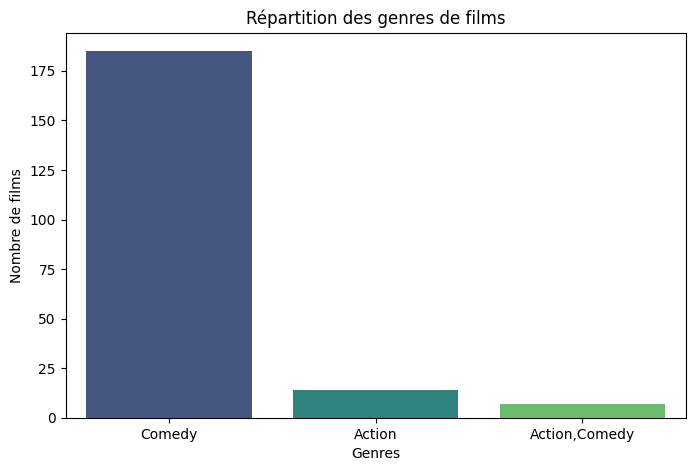

In [ ]:

# Création du diagramme à barres pour illustrer la répartition des films
fig, axes = plt.subplots(figsize=(8, 5))
sns.barplot(x="genres", y="count", data=df_count_genres, palette="viridis", hue='genres')

# Ajout des titres et labels
plt.title("Répartition des genres de films")
plt.xlabel("Genres")
plt.ylabel("Nombre de films")

# Affichage du graphique
plt.show()

In [ ]:
# répartition des films en fonction des 5 dernière année
df_films_annee = df_français_comedy_action['annee_sortie'].value_counts().reset_index()
df_films_annee

,annee_sortie,count
0,2022,81
1,2021,51
2,2020,48
3,2023,25
4,2024,1


In [ ]:
df_films_annee['annee_sortie'].tolist()

[2022, 2021, 2020, 2023, 2024]

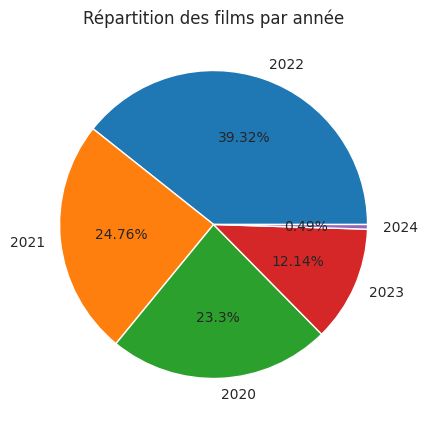

In [ ]:
# répartition des films en fonction des 5 dernière année
df_films_annee = df_français_comedy_action['annee_sortie'].value_counts().reset_index()
df_films_annee

# Création du diagramme à barres pour illustrer la répartition des films
fig, axes = plt.subplots(figsize=(8, 5))

sns.set_style("whitegrid") # Set style for chart

data = df_films_annee['count'].tolist()
labels = df_films_annee['annee_sortie'].tolist()

plt.pie(data,
        labels=labels,
        autopct = lambda x: str(round(x, 2)) + '%')

# Ajout des titres et labels
plt.title("Répartition des films par année")


# Affichage du graphique
plt.show()

# Statistiques sur la durée des films

In [ ]:
# la moyenne des films est de 96mn soit un peu plus de 1h30
df_français_comedy_action['duree'].describe()

,duree
count,206.000000
mean,96.728155
std,11.041115
min,59.000000
25%,89.000000
50%,97.000000
75%,103.750000
max,139.000000


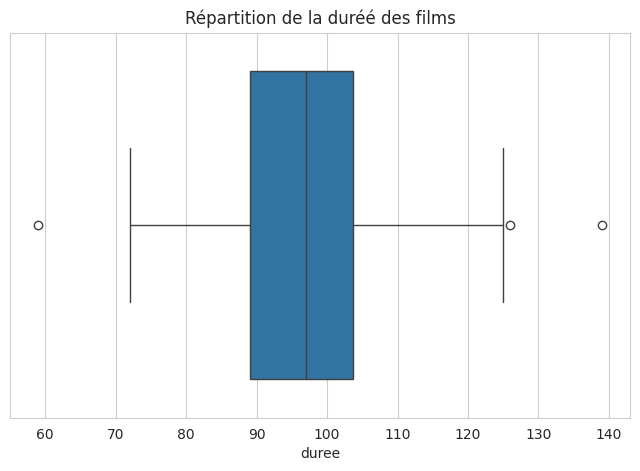

In [ ]:
# répartition dans un boxplot pour voir sa distribution

# Création du diagramme à barres pour illustrer la répartition des films
fig, axes = plt.subplots(figsize=(8, 5))
sns.boxplot(x="duree", data=df_français_comedy_action)

# Ajout des titres et labels
plt.title("Répartition de la duréé des films")

# Affichage du graphique
plt.show()

Résumé de l'interprétation

* La majorité des films durent entre 90 et 105 minutes.
* La durée médiane est autour de 95 minutes, ce qui est typique pour des films.
* Quelques films ont une durée atypique (outliers), soit très courte (60 min) ou très longue (140 min).